# Telco Churn Analysis Report
## By: Justin Sullivan
### <font color=grey> March 9, 2021

--------------------------

## Report Overview

This report is a analysis of **what is driving customer churn at Telco** and includes:
- Project **Summary**
- Process for **data acquisition** and **data preparation**
- Selected findings from **Data Exploration** and **Hypothesis testing**
- Presentation of curated **Models** developed for predicting customer churn
- **Reccomendations** from findings

## Project Summary

### <font color=grey> Key Findings: </font>
- 27% of all customers churn
- Two drivers of churn discovered in exploration and testing:
    - Bill Pay Method where customers with auto pay churn at lower rates
    - Customers who churn have higher monthly charges
- Baseline accuracy model for predicting churn has an accuracy of 74%
- The Random Forest Classifier model at the end of this report achieves an 80% accuracy rate on out of sample data

## Data Acquisition

Import tools and modules necessary for analysis.
The acquire.py, prepare.py, and explore.py modules are included in the parent repo.

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

#standard imports
import numpy as np
import pandas as pd
import os

#stats tools
from math import sqrt
from scipy import stats
from scipy.stats import ttest_ind_from_stats

#visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#env & modules
from env import host, user, password
import acquire
import prepare
import explore

##### Acquire the Data

In [2]:
#Utilize the acquire module
telco = acquire.get_telco_data()

##### Initial dataframe exploration

In [3]:
telco.shape
print(f'The telco dataframe has {telco.shape[1]} columns and {telco.shape[0]} rows')

The telco dataframe has 24 columns and 7043 rows


In [4]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [5]:
#Review summary stats for numeric columns
telco.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [6]:
#How many unique values are in each column? 
for col in telco:
    print(f'{col} has: ...............{telco[col].nunique()} unique values.')

payment_type_id has: ...............4 unique values.
contract_type_id has: ...............3 unique values.
internet_service_type_id has: ...............3 unique values.
customer_id has: ...............7043 unique values.
gender has: ...............2 unique values.
senior_citizen has: ...............2 unique values.
partner has: ...............2 unique values.
dependents has: ...............2 unique values.
tenure has: ...............73 unique values.
phone_service has: ...............2 unique values.
multiple_lines has: ...............3 unique values.
online_security has: ...............3 unique values.
online_backup has: ...............3 unique values.
device_protection has: ...............3 unique values.
tech_support has: ...............3 unique values.
streaming_tv has: ...............3 unique values.
streaming_movies has: ...............3 unique values.
paperless_billing has: ...............2 unique values.
monthly_charges has: ...............1585 unique values.
total_charges has:

#### Visulalize Select Features

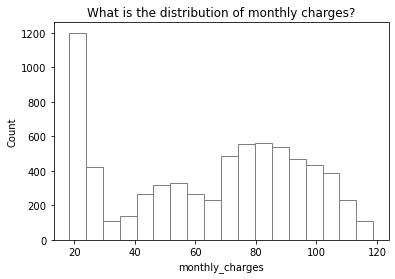

In [7]:
#Visualize a couple features to
sns.histplot(data=telco.monthly_charges, color='white', edgecolor='grey')
plt.title('What is the distribution of monthly charges?')
plt.show()

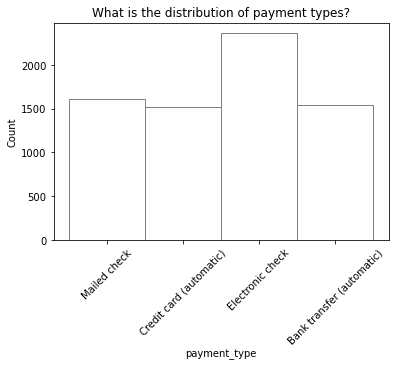

In [8]:
#Visualize another variable: Distribution of payment types
sns.histplot(data=telco.payment_type, color='white', edgecolor='grey')
plt.title('What is the distribution of payment types?')
plt.xticks(rotation=45)
plt.show()

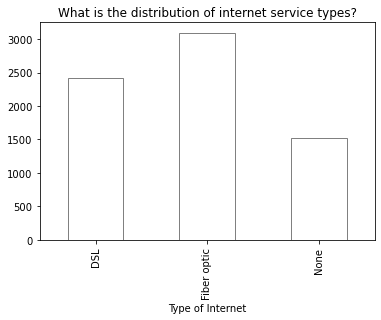

In [9]:
#Plot Internet Service Type as an example of a feature 
telco.internet_service_type.value_counts().sort_index().plot.bar(color=(0.0, 0.0, 0.0, 0.0), edgecolor='grey')
plt.title(f"What is the distribution of internet service types?")
plt.xlabel('Type of Internet')
plt.show()

### Acquire Takeaways
   - **Appears there are no null values**
        - Incorrect...There were empyt strings in the total_charges column that had to be dealt with
   - **Columns that need to be cleaned and prepared:**
        - total_charges ==> Need to convert from object to float
   - **Prep Questions:**
        - Some columns have more unique values than expected...Why?
            - online_security
            - online_backup
            - device_protection
            - tech_support
            - streaming_tv
            - streaming_movies

-----

## Data Preparation

The prepare.py module prepares the telco dataframe for analysis by:
- 1. Updating the values in the dataframe that are strings reading "No internet service" and "No phone service" and converting these to 0.
- 2. Renaming the 'payment_type_id' column to "auto_bill_pay" and grouping payment id types into two subgroups:
    - Auto Bill Pay == 1
    - Manual Bill Pay == 0
- 3. Encoding gender
- 4. Dropping columns with duplicate information
- 5. Dealing with empty strings from the 'total_charges' column. These strings are empty because the corresponding customer is in their first month of tenure and thus their total_charges are currently empty. To deal with this, I have filled those empty values with the corresponding monthly charge amount.
   

In [10]:
#Clean the df by applying the prep_data function
telco = prepare.prep_data(telco)

In [11]:
#Review the info for the prepared dataframe:
telco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0003-MKNFE to 9975-GPKZU
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   auto_bill_pay             7043 non-null   int64  
 1   contract_type_id          7043 non-null   int64  
 2   internet_service_type_id  7043 non-null   int64  
 3   senior_citizen            7043 non-null   int64  
 4   partner                   7043 non-null   int64  
 5   dependents                7043 non-null   int64  
 6   tenure                    7043 non-null   int64  
 7   phone_service             7043 non-null   int64  
 8   multiple_lines            7043 non-null   int64  
 9   online_security           7043 non-null   int64  
 10  online_backup             7043 non-null   int64  
 11  device_protection         7043 non-null   int64  
 12  tech_support              7043 non-null   int64  
 13  streaming_tv              7043 non-null   int64  
 14

In [12]:
 #Define the categorical and quantitative variables:
cat_vars = ['churn', 'senior_citizen', 'partner', 'dependents', 'phone_service', 
            'multiple_lines','online_security', 'online_backup', 'device_protection', 
            'tech_support', 'streaming_tv','streaming_movies', 'paperless_billing',
       'internet_service_type_id','gender_Male', 'contract_type_id' , 'auto_bill_pay']
quant_vars = ['tenure', 'monthly_charges', 'total_charges']

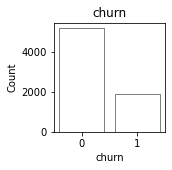

   churn  Count  Percent
0      0   5174    73.46
1      1   1869    26.54
_________________________________________________________________


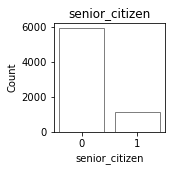

   senior_citizen  Count  Percent
0               0   5901    83.79
1               1   1142    16.21
_________________________________________________________________


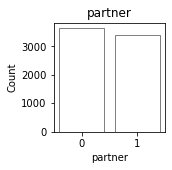

   partner  Count  Percent
0        0   3641     51.7
1        1   3402     48.3
_________________________________________________________________


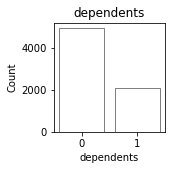

   dependents  Count  Percent
0           0   4933    70.04
1           1   2110    29.96
_________________________________________________________________


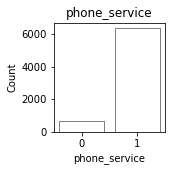

   phone_service  Count  Percent
1              1   6361    90.32
0              0    682     9.68
_________________________________________________________________


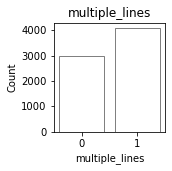

   multiple_lines  Count  Percent
0               1   4072    57.82
1               0   2971    42.18
_________________________________________________________________


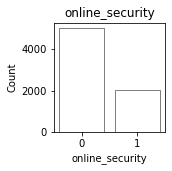

   online_security  Count  Percent
0                0   5024    71.33
1                1   2019    28.67
_________________________________________________________________


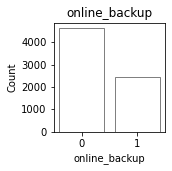

   online_backup  Count  Percent
0              0   4614    65.51
1              1   2429    34.49
_________________________________________________________________


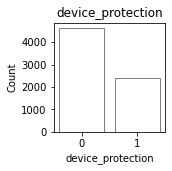

   device_protection  Count  Percent
0                  0   4621    65.61
1                  1   2422    34.39
_________________________________________________________________


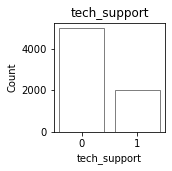

   tech_support  Count  Percent
0             0   4999    70.98
1             1   2044    29.02
_________________________________________________________________


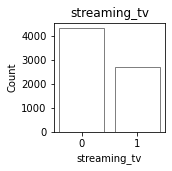

   streaming_tv  Count  Percent
0             0   4336    61.56
1             1   2707    38.44
_________________________________________________________________


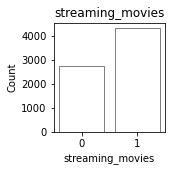

   streaming_movies  Count  Percent
0                 1   4311    61.21
1                 0   2732    38.79
_________________________________________________________________


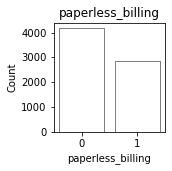

   paperless_billing  Count  Percent
1                  0   4171    59.22
0                  1   2872    40.78
_________________________________________________________________


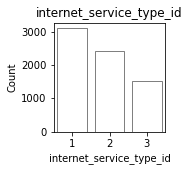

   internet_service_type_id  Count  Percent
2                         1   3096    43.96
1                         2   2421    34.37
3                         3   1526    21.67
_________________________________________________________________


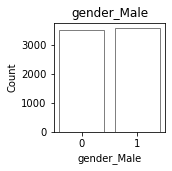

   gender_Male  Count  Percent
1            1   3555    50.48
0            0   3488    49.52
_________________________________________________________________


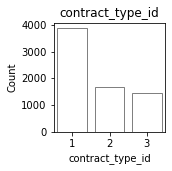

   contract_type_id  Count  Percent
1                 1   3875    55.02
3                 2   1695    24.07
2                 3   1473    20.91
_________________________________________________________________


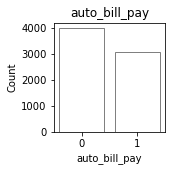

   auto_bill_pay  Count  Percent
0              0   3977    56.47
1              1   3066    43.53
_________________________________________________________________


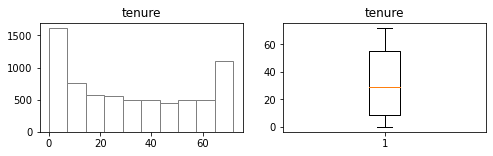

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


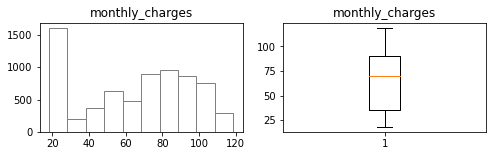

count    7043.000000
mean       64.761692
std        30.090047
min        18.250000
25%        35.500000
50%        70.350000
75%        89.850000
max       118.750000
Name: monthly_charges, dtype: float64


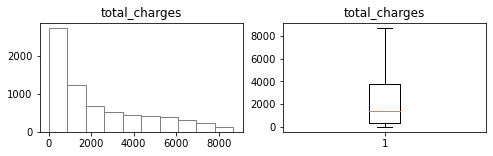

count    7043.000000
mean     2279.798992
std      2266.730170
min        18.800000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: total_charges, dtype: float64


In [13]:
#Visualize the univariate variables with the help of the explore module
explore.explore_univariate(telco, cat_vars, quant_vars)

### Takeaways:
   - With more time, I would explore the different ways of dealing with the "No Internet / No Phone Service" impacts the analysis.
   - Ancillary services (Online_protection, streaming services, device_protection, etc.) are generally under-utilized by customers with a significant majority of customers not having these services. 

------

## Data Exploration

### <font color=grey> Baseline Accuracy
- The first step of the exploration process was to establish the baseline prediction and baseline accuracy using the entire data set.
- The baseline prediction will be "no churn" since that is the more recurring class for churn.

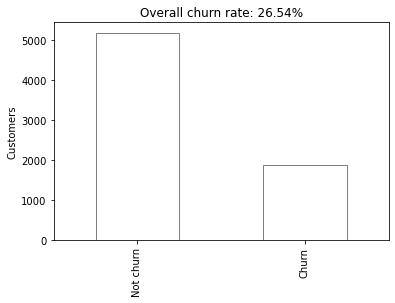

In [14]:
#Plot churn rates
telco.churn.value_counts().sort_index().plot.bar(color=(0.0, 0.0, 0.0, 0.0), edgecolor='grey')
churn_rate = telco.churn.mean()
plt.title(f"Overall churn rate: {churn_rate:.2%}")
plt.ylabel("Customers")
plt.xticks((0,1),["Not churn", "Churn"])
plt.show()

In [15]:
#Create a column for the baseline prediction and set it to 0 == No Churn 
telco['baseline_prediction'] = 0

#Calcualte the baseline_accuracy for evaluating future models
baseline_accuracy = (telco.baseline_prediction == telco.churn).mean()

print(f'Baseline accuracy: {baseline_accuracy:.2%}')

Baseline accuracy: 73.46%


### <font color=grey> Train, Validate, Test Split
- The next step is to split the data into 3 different dataframes using the function from the explore module
- The dataframes are stratfied but the target variable, churn
- All further exploration will be done on the train dataframe only

In [16]:
train, validate, test = explore.train_validate_test_split(telco, target='churn', seed=123)
print(f'The telco train dataframe has {train.shape[0]} rows and {train.shape[1]} columns.')

The telco train dataframe has 3943 rows and 21 columns.


### <font color=grey> Hypothesis Testing

### Test 1: Chi^2 Test
##### Do customers who auto pay churn at different rates than customers who manual pay?
- H<sub>o</sub> : Payment method is a not an indicator whether a customer will churn or not. 
- H<sub>*a*</sub> :  Payment method is an indicator of customer churn.

In [17]:
#Set confidence interval and alpha for chi^2 test
confidence_int = .95
a = 1 - confidence_int

#Setup crosstab
observed = pd.crosstab(train['churn'], train['auto_bill_pay'] )

#Run Chi test
chi2, p, degf, expected = stats.chi2_contingency(observed)

#Evaluate against the null hypothesis
if p < a:
    print("Reject the null hypothesis")
    print("Move forward with the understanding that payment method is a feature for indicating churn.")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis
Move forward with the understanding that payment method is a feature for indicating churn.


##### Bil Pay Feature Visualization
Peek at the rate of churn based on bill pay method

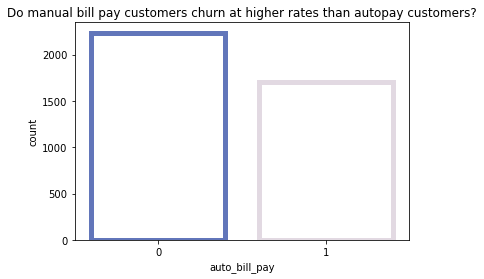

In [18]:
ax = sns.countplot(x="auto_bill_pay", data=train,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("twilight_shifted", 3))

plt.title("Do manual bill pay customers churn at higher rates than autopay customers?")
plt.show()

### Test 2: Two-sample, two-tailed T-test
##### Do customers who churn have a higher monthly bill on average than customers who do not churn
- H<sub>o</sub> : Monthly bill has no impact on customer churn. 
- H<sub>*a*</sub> :  Customers with higher monthly bills churn more.

In [32]:
#Set confidence interval and alpha for t-test
confidence_int = .95
a = 1 - confidence_int

x1 = train[train.churn == 0].monthly_charges
x2 = train[train.churn == 1].monthly_charges

#Run t-test
stats.ttest_ind(x1, x2)

#Evaluate against the null hypothesis
if p < a:
    print("Reject the null hypothesis")
    print("Move forward with the understanding that higher monthly charges is a feature impacting churn.")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis
Move forward with the understanding that higher monthly charges is a feature impacting churn.


##### Monthly Charges Feature Visualization
Peek at the rate of churn based on monthly-charges over time of tenure

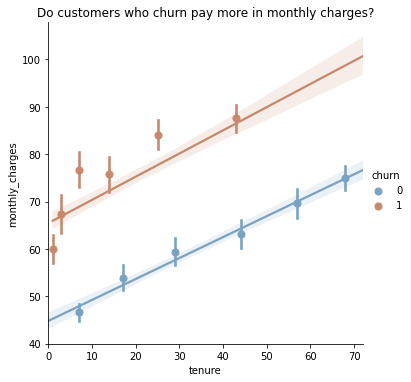

In [20]:
#Visualize the relatinship between monthly charges and churn at stages of customer tenure
sns.lmplot(data=train, x='tenure', y='monthly_charges', hue = 'churn', x_bins=6, x_estimator=np.mean, palette="twilight_shifted")
plt.title("Do customers who churn pay more in monthly charges?")
plt.show()

#### Hypothesis Testing Takeaways:
    - Payment type and monthly charges are likely features driving churn
    - Customers who churn pay more in monthly charges at all stages of tenure

### <font color=grey> Bivariate Exploration 

senior_citizen 
_____________________

         chi2       p-value  degrees of freedom
0  106.292446  6.361851e-25                   1

observed:
 churn              0     1   All
senior_citizen                  
0               2532   770  3302
1                365   276   641
All             2897  1046  3943

expected:
              0           1
0  2426.044636  875.955364
1   470.955364  170.044636


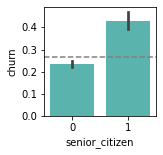


_____________________

partner 
_____________________

        chi2       p-value  degrees of freedom
0  59.095958  1.501674e-14                   1

observed:
 churn       0     1   All
partner                  
0        1383   645  2028
1        1514   401  1915
All      2897  1046  3943

expected:
              0           1
0  1490.011666  537.988334
1  1406.988334  508.011666


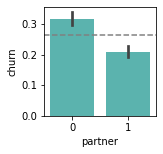


_____________________

dependents 
_____________________

         chi2       p-value  degrees of freedom
0  104.078831  1.944245e-24                   1

observed:
 churn          0     1   All
dependents                  
0           1887   859  2746
1           1010   187  1197
All         2897  1046  3943

expected:
              0           1
0  2017.540451  728.459549
1   879.459549  317.540451


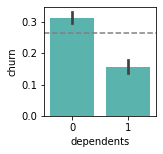


_____________________

phone_service 
_____________________

       chi2   p-value  degrees of freedom
0  0.031921  0.858201                   1

observed:
 churn             0     1   All
phone_service                  
0               276    97   373
1              2621   949  3570
All            2897  1046  3943

expected:
              0           1
0   274.050469   98.949531
1  2622.949531  947.050469


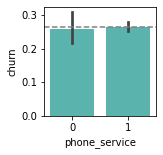


_____________________

multiple_lines 
_____________________

       chi2   p-value  degrees of freedom
0  4.242562  0.039423                   1

observed:
 churn              0     1   All
multiple_lines                  
0               1698   574  2272
1               1199   472  1671
All             2897  1046  3943

expected:
              0           1
0  1669.283287  602.716713
1  1227.716713  443.283287


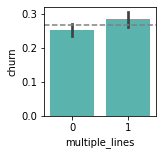


_____________________

online_security 
_____________________

        chi2       p-value  degrees of freedom
0  91.853993  9.331342e-22                   1

observed:
 churn               0     1   All
online_security                  
0                1940   865  2805
1                 957   181  1138
All              2897  1046  3943

expected:
              0           1
0  2060.888917  744.111083
1   836.111083  301.888917


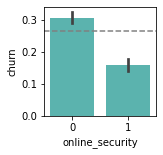


_____________________

online_backup 
_____________________

        chi2   p-value  degrees of freedom
0  20.992487  0.000005                   1

observed:
 churn             0     1   All
online_backup                  
0              1863   755  2618
1              1034   291  1325
All            2897  1046  3943

expected:
              0           1
0  1923.496323  694.503677
1   973.503677  351.496323


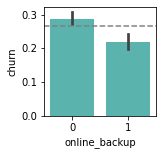


_____________________

device_protection 
_____________________

        chi2   p-value  degrees of freedom
0  17.652315  0.000027                   1

observed:
 churn                 0     1   All
device_protection                  
0                  1865   749  2614
1                  1032   297  1329
All                2897  1046  3943

expected:
              0           1
0  1920.557444  693.442556
1   976.442556  352.557444


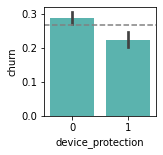


_____________________

tech_support 
_____________________

         chi2       p-value  degrees of freedom
0  111.221776  5.290815e-26                   1

observed:
 churn            0     1   All
tech_support                  
0             1941   881  2822
1              956   165  1121
All           2897  1046  3943

expected:
              0           1
0  2073.379153  748.620847
1   823.620847  297.379153


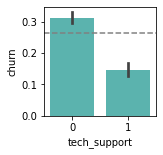


_____________________

streaming_tv 
_____________________

        chi2   p-value  degrees of freedom
0  17.559103  0.000028                   1

observed:
 churn            0     1   All
streaming_tv                  
0             1854   592  2446
1             1043   454  1497
All           2897  1046  3943

expected:
              0           1
0  1797.124524  648.875476
1  1099.875476  397.124524


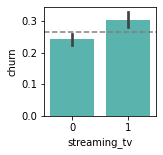


_____________________

streaming_movies 
_____________________

       chi2   p-value  degrees of freedom
0  12.56845  0.000392                   1

observed:
 churn                0     1   All
streaming_movies                  
0                 1822   592  2414
1                 1075   454  1529
All               2897  1046  3943

expected:
              0           1
0  1773.613492  640.386508
1  1123.386508  405.613492


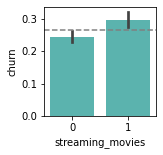


_____________________

paperless_billing 
_____________________

         chi2       p-value  degrees of freedom
0  142.836865  6.381161e-33                   1

observed:
 churn                 0     1   All
paperless_billing                  
0                  1359   268  1627
1                  1538   778  2316
All                2897  1046  3943

expected:
              0           1
0  1195.389044  431.610956
1  1701.610956  614.389044


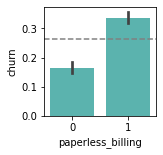


_____________________

internet_service_type_id 
_____________________

         chi2       p-value  degrees of freedom
0  405.080731  1.091031e-88                   2

observed:
 churn                        0     1   All
internet_service_type_id                  
1                         1077   260  1337
2                         1018   725  1743
3                          802    61   863
All                       2897  1046  3943

expected:
              0           1
0   982.320314  354.679686
1  1280.616536  462.383464
2   634.063150  228.936850


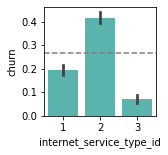


_____________________

gender_Male 
_____________________

       chi2   p-value  degrees of freedom
0  0.927191  0.335594                   1

observed:
 churn           0     1   All
gender_Male                  
0            1473   513  1986
1            1424   533  1957
All          2897  1046  3943

expected:
              0           1
0  1459.153436  526.846564
1  1437.846564  519.153436


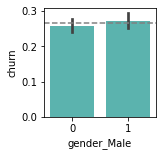


_____________________

contract_type_id 
_____________________

         chi2        p-value  degrees of freedom
0  625.295741  1.654837e-136                   2

observed:
 churn                0     1   All
contract_type_id                  
1                 1269   919  2188
2                  730   103   833
3                  898    24   922
All               2897  1046  3943

expected:
              0           1
0  1607.566827  580.433173
1   612.021557  220.978443
2   677.411616  244.588384


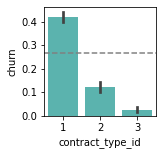


_____________________

auto_bill_pay 
_____________________

         chi2       p-value  degrees of freedom
0  151.977733  6.407558e-35                   1

observed:
 churn             0     1   All
auto_bill_pay                  
0              1473   763  2236
1              1424   283  1707
All            2897  1046  3943

expected:
              0           1
0  1642.833376  593.166624
1  1254.166624  452.833376


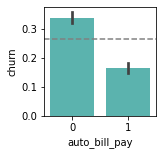


_____________________

tenure 
____________________



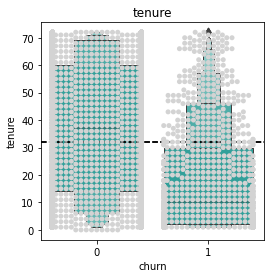

        count       mean        std  min   25%   50%   75%   max
churn                                                           
0      2897.0  37.021056  24.067195  0.0  14.0  37.0  60.0  72.0
1      1046.0  18.228489  19.391963  1.0   2.0  10.0  30.0  72.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2215778.5, pvalue=2.6225178502743525e-109)

____________________

monthly_charges 
____________________



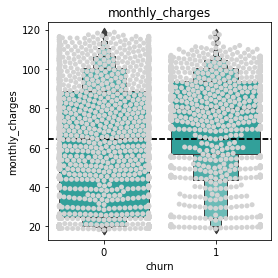

        count       mean        std    min      25%    50%      75%     max
churn                                                                      
0      2897.0  61.176976  31.293724  18.25  25.0500  64.35  88.9500  118.65
1      1046.0  74.376052  24.624883  18.85  56.8125  79.50  94.0375  118.35 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1149040.0, pvalue=4.103131725466243e-31)

____________________

total_charges 
____________________



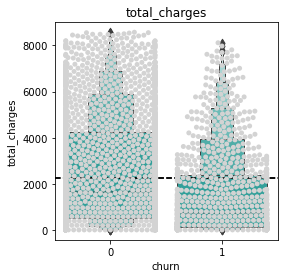

        count         mean          std    min       25%      50%        75%  \
churn                                                                          
0      2897.0  2521.965412  2334.005662  18.80  538.2000  1640.00  4250.1000   
1      1046.0  1538.818499  1856.338676  18.85  139.3625   768.05  2386.1125   

           max  
churn           
0      8564.75  
1      8109.80   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1944421.5, pvalue=3.84641772859757e-42)

____________________



In [21]:
#Update categorical variables by removing target variable, churn
cat_vars = cat_vars[1:]

#Explore the bivariate variables
explore.explore_bivariate(train,'churn', cat_vars, quant_vars)

#### Bivariate Exploration Takeaways:
- Rate of churn is fairly equal for customers with phone service vs. customers without phone service
- Customers without auxillary services churn at higher rates than customers with those services
    - Explore the relationship between these services and consider developing new features
- Streaming TV customers churn more...That is different from other auxillary services
- Paperless billing customers churn at high rates
- Fiber customers churn at higher rates than the other internet services options

### <font color=grey> Multivariate Exploration

#### For multivariate exploration, I focused on the interplay between the auxillary services features and the quantitative features in exploration of churn.

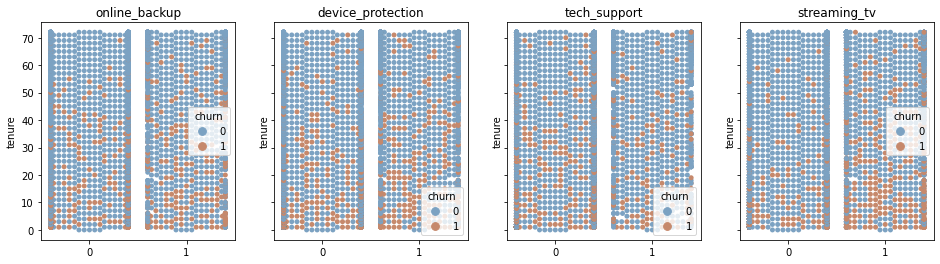

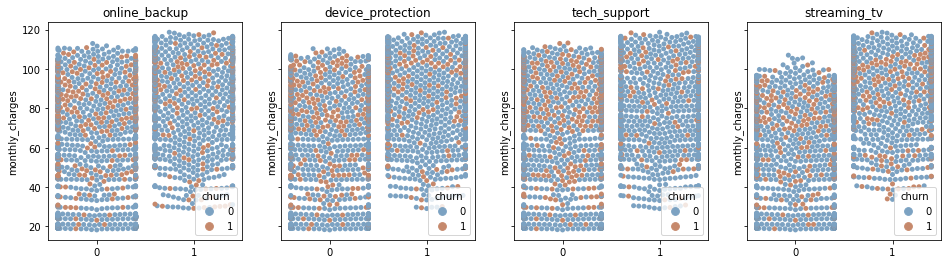

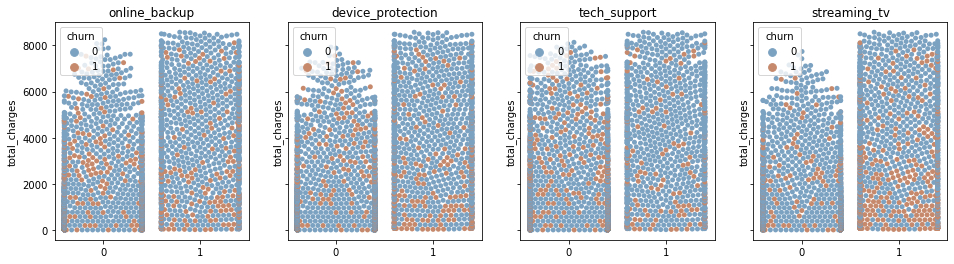

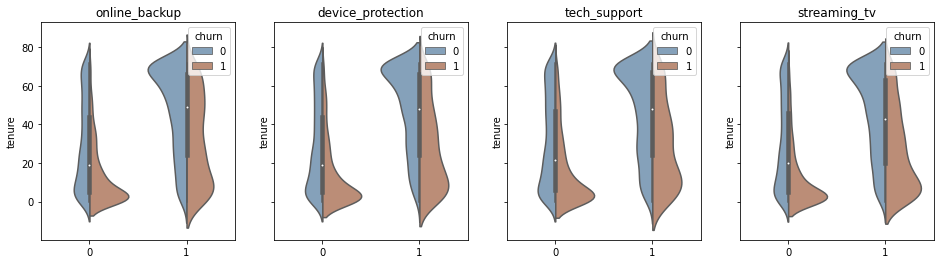

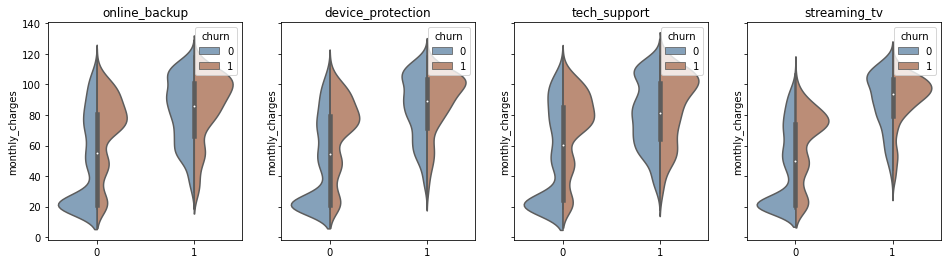

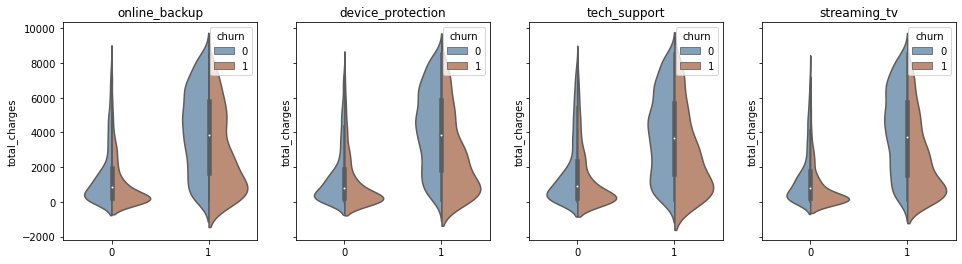

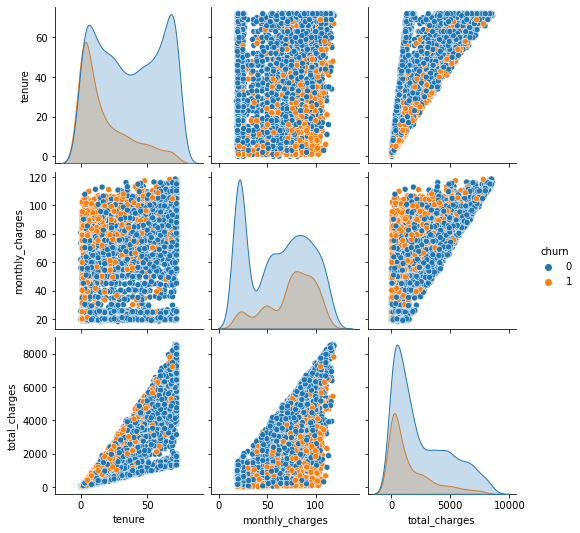

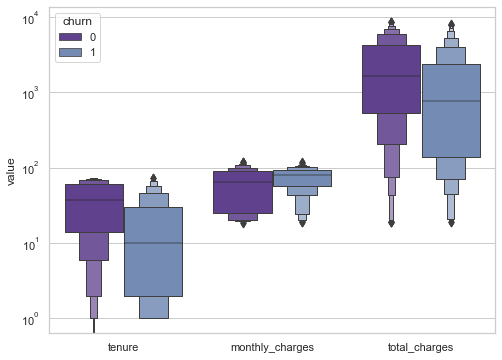

In [22]:
target = 'churn'

explore.explore_multivariate(train, target, cat_vars[6:10], quant_vars)

#### Multivariate Exploration Takeaways:
- Customers with streaming tv services seem to churn at higher rates earlier in their tenure
     - Other services also appear to follow this trend but do not appear as prominent
- Honestly, there is a lot of information presented in these features to analyze. Due to the fact that these are auxillary services and in the interest of time, I am setting these features aside for this analsis and adding them to the list of features to explore more in the future.
        

---

## Modeling & Evaluation

### <font color=grey> Model 1: Logistic Regression

In [23]:
dropped_features = ['churn','baseline_prediction']

#Split train into X_train, y_train
X_train = train.drop(columns=dropped_features)
y_train = train.churn

#Split validate into X_validate, y_validate
X_validate = validate.drop(columns=dropped_features)
y_validate = validate.churn

#Split test into X_test, y_test
X_test = test.drop(columns=dropped_features)
y_test = test.churn

#Create the Object
logit = LogisticRegression(C=1, class_weight='balanced', random_state=123, intercept_scaling=1, solver='lbfgs')

#Fit the training data to the model
logit.fit(X_train, y_train)

#Make predictions
y_pred = logit.predict(X_train)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

print(classification_report(y_train, y_pred))

Accuracy of Logistic Regression classifier on training set: 0.74
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      2897
           1       0.51      0.80      0.62      1046

    accuracy                           0.74      3943
   macro avg       0.71      0.76      0.71      3943
weighted avg       0.80      0.74      0.76      3943



<div class="alert alert-block alert-warning">This model's accuracy is essentially the same as the baseline accuracy. Therefore, this model is immediately rejected. </div>

### <font color=grey> Model 2: KNN with K = 5

In [24]:
features = ['contract_type_id', 'tenure', 'monthly_charges', 
                    'total_charges', 'internet_service_type_id']
dropped_features = ['churn','senior_citizen', 'partner', 'dependents', 'phone_service',
                    'multiple_lines', 'online_security', 'online_backup', 'device_protection',
                    'streaming_tv','streaming_movies','tech_support', 'paperless_billing',  
                    'baseline_prediction']

#Split train into X_train, y_train
X_train = train.drop(columns=dropped_features)
y_train = train.churn

#Split validate into X_validate, y_validate
X_validate = validate.drop(columns=dropped_features)
y_validate = validate.churn

#Split test into X_test, y_test
X_test = test.drop(columns=dropped_features)
y_test = test.churn

#Create the object
knn_2 = KNeighborsClassifier(n_neighbors=5, weights='uniform')

#Fit the training data to the model
knn_2.fit(X_train, y_train)

#Make Predictions
y_pred_2 = knn_2.predict(X_train)

print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn_2.score(X_train, y_train)))

print(classification_report(y_train, y_pred_2))

Accuracy of KNN classifier on training set: 0.83
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      2897
           1       0.72      0.56      0.63      1046

    accuracy                           0.83      3943
   macro avg       0.79      0.74      0.76      3943
weighted avg       0.82      0.83      0.82      3943



### <font color=grey> Model 3: KNN with K = 2

In [25]:
#Create the object
knn_3 = KNeighborsClassifier(n_neighbors=2, weights='uniform')

#Fit the training data to the model
knn_3.fit(X_train, y_train)

#Make predictions
y_pred_3 = knn_3.predict(X_train)

#Report
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn_3.score(X_train, y_train)))

print(classification_report(y_train, y_pred_3))

Accuracy of KNN classifier on training set: 0.86
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2897
           1       1.00      0.46      0.63      1046

    accuracy                           0.86      3943
   macro avg       0.92      0.73      0.77      3943
weighted avg       0.88      0.86      0.84      3943



### <font color=grey> Model 4: Random Forest

In [26]:
#Create the object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)

#Fit the data to the model
rf.fit(X_train, y_train)

#Make Predictions
y_pred_4 = rf.predict(X_train)

print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

print(classification_report(y_train, y_pred_4))

Accuracy of random forest classifier on training set: 0.80
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2897
           1       0.68      0.46      0.54      1046

    accuracy                           0.80      3943
   macro avg       0.75      0.69      0.71      3943
weighted avg       0.79      0.80      0.78      3943



### Takeaways:
- Model 1 has the same accuracy as the baseline and it is rejected. 
- Models 2, 3 & 4 performed the best on in-sample data.
- Next is to evaluate these models on the validate data frame

### <font color=grey> Evaluate Models with Validate Dataframe

In [27]:
#Make predictions with Model 2
y_pred_2 = knn_2.predict(X_validate)

#Make predictions with Model 3
y_pred_3 = knn_3.predict(X_validate)

#Make predictions with Model 4
y_pred_4 = rf.predict(X_validate)

#Evaluate Model 2
print('Model 2 accuracy of KNN classifier with K=5 on validate set: {:.2f}'
     .format(knn_2.score(X_validate, y_validate)))
print(classification_report(y_validate, y_pred_2))
print('------------')

#Evaluate Model 3

print('Model 3 accuracy of KNN classifier with K=2 on validate set: {:.2f}'
     .format(knn_3.score(X_validate, y_validate)))
print(classification_report(y_validate, y_pred_3))  
print('------------')

#Evaluate Model 4

print('Model 4 accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))
print(classification_report(y_validate, y_pred_4))

Model 2 accuracy of KNN classifier with K=5 on validate set: 0.76
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1242
           1       0.56      0.48      0.52       449

    accuracy                           0.76      1691
   macro avg       0.69      0.67      0.68      1691
weighted avg       0.75      0.76      0.76      1691

------------
Model 3 accuracy of KNN classifier with K=2 on validate set: 0.76
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      1242
           1       0.61      0.30      0.40       449

    accuracy                           0.76      1691
   macro avg       0.70      0.61      0.63      1691
weighted avg       0.74      0.76      0.73      1691

------------
Model 4 accuracy of random forest classifier on validate set: 0.79
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1242
           1

#### Takeaways:
    - Model 4 performed the best on out of sample data.
    - Proceed to test with model 4

### <font color=grey> Evaluate Model 4 (RF) with Test Dataframe

In [28]:
y_pred_4 = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

print(f'Confusion matrix: \n {confusion_matrix(y_test, y_pred_4)}\n')

print('Accuracy of random forest classifier on test set: {:.2f}\n'
     .format(rf.score(X_test, y_test)))

print(classification_report(y_test, y_pred_4))

Confusion matrix: 
 [[961  74]
 [202 172]]

Accuracy of random forest classifier on test set: 0.80

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      1035
           1       0.70      0.46      0.55       374

    accuracy                           0.80      1409
   macro avg       0.76      0.69      0.71      1409
weighted avg       0.79      0.80      0.79      1409



#### Takeaways:
- Model 4 performed slighty better on the out of sample test dataframe with accuracy of 80%
- This model performs better than the baseline model and will be kept until a more accurate model is produced

---

## Reccomendations
- **1. Incentivize customers for enrolling in auto bill pay.**
- **2. Monthly charges is a driver of churn but we do not want to decrease revenue.** 
    - **Instead, since the majority of our customers do not currently utilize auxillary services such as device protection, tech-support, etc.**
    - **Telco should identfiy this as an opportunity to promote these services by offering free-trials to customers. Not only will these assist with promoting these services, but it could also improve the perceived value of the monthly charges.**

---

## Conclusion

- **27% of Telco customers churn**
- **Bill pay method is a driver of churn supported by the Chi^2 statistical test at 95% confidence interval**
- **Monthly Charges is a driver of churn supported by the T-test statistical test with a 95% confidence interval**
- **Model 4 is a Random Forest Classifier model devloped to predict customer churn. It performed with 80% accuracy on out of sample data, beating the basline accuracy model.**

---

## Appendix:
### Prepare Deliverables
#### The code below prepares a csv file of the test dataframe where each observation is a customer with the probability of churn and prediction of churn. 

In [29]:
#Write predictions and probability of churn to csv

#drop columns on entire test dataframe to match X_test
test.drop(columns=['churn','senior_citizen', 'partner', 'dependents', 'phone_service',
                    'multiple_lines', 'online_security', 'online_backup', 'device_protection',
                    'streaming_tv','streaming_movies', 'paperless_billing',  
                    'baseline_prediction', 'tech_support'], inplace=True)

#Calculate the predictions and probability for the test dataframe
y_pred_final = rf.predict(test)
y_pred_proba = rf.predict_proba(test)

#Create a prediction column and fill with values
test['churn_prediction'] = y_pred_final

#Create a probability column and fill with values
#Note: Need to transform the array and take index 1 values ==> probability FOR churn
test['churn_probability'] = y_pred_proba.T[1]

#Drop columns not needed for csv
test.drop(columns=['contract_type_id', 'auto_bill_pay', 'tenure', 'monthly_charges', 
                    'total_charges', 'internet_service_type_id', 'gender_Male'], inplace=True)

#Write to CSV
#test.to_csv('telco_churn_pred_and_proba.csv', index=True)